<a href="https://colab.research.google.com/github/toskpl/Challenge_DW/blob/master/part3/day4/day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#wybieramy runtime type GPU
#wypisuje informacje poniżej
!nvidia-smi

Fri Mar 13 23:18:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#instalacja imgaug
!pip install imgaug

from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random

from sklearn.model_selection import train_test_split

In [0]:
#wczytanie danych z pliku
X = np.load('X.npy')
y =  np.load('y.npy')

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense, Dropout,MaxPooling2D,Lambda

!pip install livelossplot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [8]:
print(X.shape,y.shape)

(5712, 60, 80, 3) (5712,)


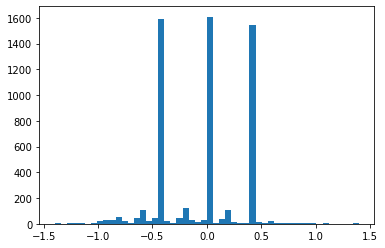

In [9]:
#pik w wartosci :
# -0.4 - skręt w lewo, mocniej skręc w lewo
#    0 - jazda na wprost
# +0.4 - skręt w prawo, mocniej skręc w prawo
plt.hist(y,50);

0.0


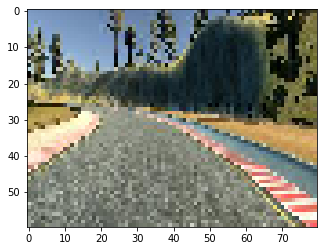

0.42500000000000004


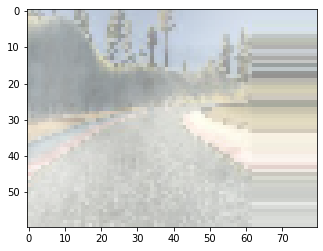

In [13]:
#funkcja przeksztalacajaca zdjecia:
#flip      - odbice w lusterze
#blur      - rozmazanie
#shuffle   - zamiana kolorów w kanale
#fog       - dodanie mgły do zdjecia
#translate - przesuniecie zdjecia

def argument(img, steering_angle):
  #Flip
  if random.random() > 0.5:
    img = img [:, ::-1, :]
    steering_angle = - steering_angle
  
  #blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 2.0))
  img = blurer.augment_image(img)
  
  #shuffle
  sh = iaa.ChannelShuffle(p =0.5)
  img = sh.augment_image(img)
  
  #fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  
  # translate
  tx = random.randint (-20,20)
  translate = iaa.Affine(translate_px = {"x":tx},mode ='edge')#mode rozciaga obraz bez czarnego paska
  img = translate.augment_image(img)
  steering_angle -= tx *0.025
  
  return (img , steering_angle)

#zdjecie po przekszatalcniu
plt.imshow(X[0])
print(y[0])

plt.show()

img, angle = argument(X[0],y[0])

plt.imshow(img)
print(angle)
plt.show()



  

In [0]:
#podzial na zbior testowy i treningowy
X_train, X_val, y_train,y_val = train_test_split(X,y, test_size = 0.2 ,random_state = 42) 

In [15]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(4569, 60, 80, 3) (4569,)
(1143, 60, 80, 3) (1143,)


In [16]:
#w petli przekszatalacenie zdjec
Xgen= []
ygen= []

for i in range(X_train.shape[0]):
  img , angle = argument(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)
  
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)

print(Xgen.shape, ygen.shape)
  

(4569, 60, 80, 3) (4569,)


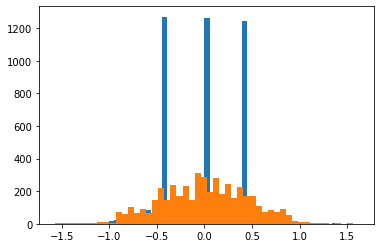

In [20]:
#histogram dla danych surowych bez przeksztalcenia 3 piki
plt.hist(y_train, 50)

#histogram dla przekszatalconych zdjec - rozrozkład zbliżony do normalnego
plt.hist(ygen,50);

In [0]:
#architektura modelu
def my_model(input_shape):
  model = Sequential ([
      Lambda(lambda x: (x-180.0)/255.0,input_shape = input_shape, name ='normalize') ,
      Conv2D (64,(3,3), activation = 'relu'),
      #MaxPooling2D(pool_size =(2,2)),
      Conv2D (32,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size =(2,2)),
      Conv2D (16,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size =(2,2)),
      Conv2D (8,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size =(2,2)),
      Dropout(rate=0.5),
      Flatten(),
      Dropout(rate=0.5),
      Dense(512, activation = 'relu'),
      Dropout(rate=0.3),
      Dense(512, activation = 'relu'),
      Dropout(rate=0.3),
      Dense(16, activation = 'relu'),
      Dense(1)
      
  ])
  return model

model = my_model(X[0].shape)

model.summary()
model.compile('adam','mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxP

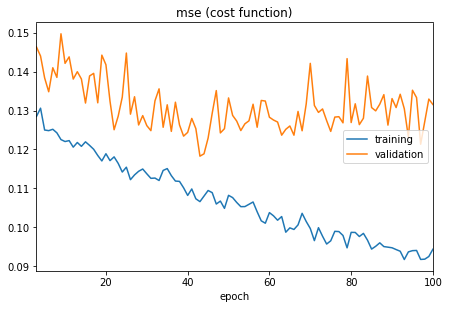

mse (cost function):
training   (min:    0.092, max:    0.132, cur:    0.094)
validation (min:    0.118, max:    0.150, cur:    0.132)


In [0]:
batch_size = 512
epochs =100

model.fit(Xgen,ygen,
         batch_size = batch_size,
         epochs = epochs,
         validation_data = (X_val,y_val),
         callbacks= [PlotLossesKeras()])

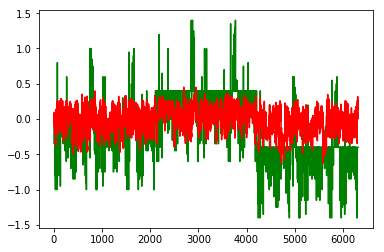

In [0]:
ypred = model.predict(X)
plt.plot(y,'g',ypred,'r')
plt.show()

In [0]:
model.save('my_model_xxx.h5')